In [60]:
import xarray as xr
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import iris

In [61]:
# Define dictionaries for the scenarios
scenarios = {
    'expt1': 'pa-pdSIC-ext',
    'expt2': 'pa-futArcSIC-ext',
    'expt3': 'pa-futAntSIC-ext',
    'expt4': 'pa-pdSIC-2XCO2-ext',
    'expt5': 'pa-futSIC-2XCO2-ext'
}

In [62]:
# Define a function to calculate transport (pr* - qflx*)
def calculate_transport(pr, qflx):
    return pr - qflx

# Create file paths for qflx and pr datasets
qflx_files = {key: f"/scratch/lvillanu/data/{value}_qflx_mean_each_month.nc" for key, value in scenarios.items()}
pr_files = {key: f"/scratch/lvillanu/data/{value}_pr_mean_each_month.nc" for key, value in scenarios.items()}

In [63]:
prc_files = {key: f"/scratch/lvillanu/data/{value}_prc_mean_each_month.nc" for key, value in scenarios.items()}

In [64]:
# Load qflx datasets
qflx_datasets = {key: iris.load(filepath)[0] for key, filepath in qflx_files.items()}

# Load pr datasets
pr_datasets = {key: iris.load(filepath)[0] for key, filepath in pr_files.items()}

prc_datasets = {key: iris.load(filepath)[0] for key, filepath in prc_files.items()}

# Define function to convert units to mm/day
def convert_to_mm_per_day(cube):
    if cube.units == 'm/s':
        # Convert from meters per second to mm/day
        # There are 86400 seconds in a day, 1000 mm in a meter
        conversion_factor = 86400 * 1000
        cube.data = cube.data * conversion_factor
        cube.units = 'mm/day'
    elif cube.units == 'kg/m2/s':
        # Convert from meters per month to mm/day
        # Average month length: 30.44 days
        conversion_factor = 86400
        cube.data = cube.data * conversion_factor
        cube.units = 'mm/day'
    elif cube.units != 'mm/day':
        raise ValueError(f"Unexpected units: {cube.units}")

    return cube

# Convert all datasets to mm/day
qflx_datasets_mm_day = {key: convert_to_mm_per_day(cube) for key, cube in qflx_datasets.items()}
pr_datasets_mm_day = {key: convert_to_mm_per_day(cube) for key, cube in pr_datasets.items()}
prc_datasets_mm_day = {key: convert_to_mm_per_day(cube) for key, cube in prc_datasets.items()}


# Define function to calculate transport
def calculate_transport(pr_cube, qflx_cube):
    # Ensure both cubes have the same dimensions and units
    if pr_cube.shape != qflx_cube.shape:
        raise ValueError("Dimension mismatch between pr and qflx cubes")
    
    # Calculate transport (pr - qflx)
    transport = pr_cube.copy()
    transport.data = pr_cube.data - qflx_cube.data
    transport.units = 'mm/day'
    return transport

# Calculate transport (pr* - qflx*)
transports = {key: calculate_transport(pr_datasets_mm_day[key], qflx_datasets_mm_day[key]) for key in scenarios.keys()}

/home/netapp-clima/users/ggiulian/m20/lib/python3.10/site-packages/iris/fileformats/_nc_load_rules/helpers.py:1178: _WarnComboDefaultingCfLoad: Failed to create 'time' dimension coordinate: The 'time' DimCoord points array must be strictly monotonic.
Gracefully creating 'time' auxiliary coordinate instead.
  warnings.warn(


In [65]:
def extract_arctic(data_in):
    """
    Extracts the Arctic region (latitude from 70 to 90 degrees) from the input data.

    Parameters:
    data_in (iris.cube.Cube): Input data cube to be constrained.

    Returns:
    iris.cube.Cube: Data cube constrained to the Arctic region.
    """
    # Define a geographical constraint for the Arctic region
    R = iris.Constraint(latitude=lambda lat: 70 <= lat <= 90,
                        longitude=lambda lon: 0 <= lon <= 360)
    
    # Extract data within the defined constraint
    data_out = data_in.extract(R)
    
    return data_out

In [66]:
# Apply extraction function to all datasets
arctic_qflx_datasets = {key: extract_arctic(cube) for key, cube in qflx_datasets_mm_day.items()}
arctic_pr_datasets = {key: extract_arctic(cube) for key, cube in pr_datasets_mm_day.items()}
arctic_transport_datasets = {key: extract_arctic(cube) for key, cube in transports.items()}
arctic_prc_datasets = {key: extract_arctic(cube) for key, cube in prc_datasets_mm_day.items()}

In [67]:
def area_weighted(data_in):
    """
    Computes the area-weighted mean of the input data across latitude and longitude.

    Parameters:
    data_in (iris.cube.Cube): Input data cube to be averaged.

    Returns:
    iris.cube.Cube: Area-weighted mean of the input data.
    """
    # Guess bounds for latitude and longitude coordinates
    data_in.coord('latitude').guess_bounds()
    data_in.coord('longitude').guess_bounds()

    # Compute the area weights for each cell
    cell_area = iris.analysis.cartography.area_weights(data_in)

    # Compute the area-weighted mean across latitude and longitude
    data_out = data_in.collapsed(['latitude', 'longitude'],
                                 iris.analysis.MEAN,
                                 weights=cell_area)
    
    return data_out

In [68]:
# Example: Apply area_weighted to each dataset in qflx_datasets_mm_day and pr_datasets_mm_day
arctic_qflx_datasets_weighted = {key: area_weighted(cube) for key, cube in arctic_qflx_datasets.items()}
arctic_pr_datasets_weighted = {key: area_weighted(cube) for key, cube in arctic_pr_datasets.items()}
arctic_transport_datasets_weighted = {key: area_weighted(cube) for key, cube in arctic_transport_datasets.items()}
arctic_prc_datasets_weighted = {key: area_weighted(cube) for key, cube in arctic_prc_datasets.items()}

/home/netapp-clima/users/ggiulian/m20/lib/python3.10/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(


In [69]:
arctic_prc_datasets_weighted['expt5'].data

masked_array(data=[0.10762634603818307, 0.0963616941731682,
                   0.08327676081076377, 0.06518570222258759,
                   0.04464730472989854, 0.04177512849155566,
                   0.057504538401637384, 0.08306527614311938,
                   0.09967748641092881, 0.12373058278649164,
                   0.16889807854133967, 0.14088684292863407],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value=1e+20)

In [70]:
arctic_pr_datasets_weighted['expt5'].data

masked_array(data=[0.8176123359842138, 0.7010714793805609,
                   0.6867685231094655, 0.6772674510070248,
                   0.6663854164937281, 0.6749097440414684,
                   0.8633425174548037, 1.1279953725869256,
                   1.3280885630955497, 1.3605831312420875,
                   1.1991040016500651, 0.9970074153195302],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value=1e+20)

In [71]:
arctic_transport_datasets_weighted['expt5'].data

masked_array(data=[0.36828559965354296, 0.3386316421248886,
                   0.35279673681405604, 0.39686758049498944,
                   0.4176957680871669, 0.3829959417353828,
                   0.5434622116524156, 0.8025008805309589,
                   1.0041295079321628, 0.9346012088802937,
                   0.5577819457553321, 0.4038732109096777],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value=1e+20)

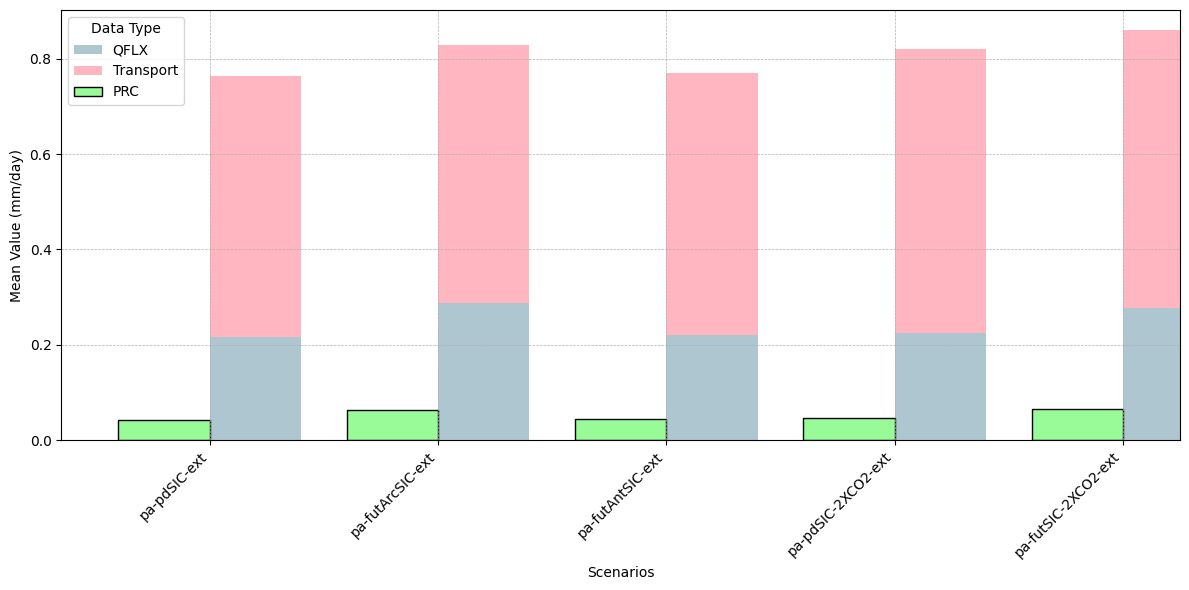

In [72]:
import iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def calculate_mean(cube):
    """
    Calculate the overall mean of a data cube.
    
    Parameters:
    cube (iris.cube.Cube): Input data cube.
    
    Returns:
    float: Mean value of the cube data.
    """
    return np.mean(cube.data)

# Calculate overall means for each dataset
mean_qflx = {key: calculate_mean(cube) for key, cube in arctic_qflx_datasets.items()}
mean_transport = {key: calculate_mean(cube) for key, cube in arctic_transport_datasets.items()}
mean_prc = {key: calculate_mean(cube) for key, cube in arctic_prc_datasets.items()}

# Prepare data for plotting
data = {
    'Experiment': [],
    'Type': [],
    'Mean Value': []
}

for key in scenarios.keys():
    data['Experiment'].append(key)
    data['Type'].append('QFLX')
    data['Mean Value'].append(mean_qflx[key])
    
    data['Experiment'].append(key)
    data['Type'].append('Transport')
    data['Mean Value'].append(mean_transport[key])
    
    data['Experiment'].append(key)
    data['Type'].append('PRC')
    data['Mean Value'].append(mean_prc[key])

df = pd.DataFrame(data)

# Pivot table for stacked bar plot
pivot_df = df.pivot(index='Experiment', columns='Type', values='Mean Value').fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot stacked bars for QFLX and Transport with pastel colors
colors = ['#AEC6CF', '#FFB6C1']  # Pastel blue and pink
pivot_df[['QFLX', 'Transport']].plot(kind='bar', stacked=True, width=0.4, color=colors, ax=ax, position=0)

# Plot separate bars for PRC
pivot_df[['PRC']].plot(kind='bar', width=0.4, color='#98FB98', edgecolor='black', ax=ax, position=1, label='Convective Precipitation')

# Adding labels and title
plt.title('')
plt.xlabel('Scenarios')
plt.ylabel('Mean Value (mm/day)')
plt.xticks(ticks=np.arange(len(scenarios)), labels=scenarios.values(), rotation=45, ha='right')
plt.legend(title='Data Type')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

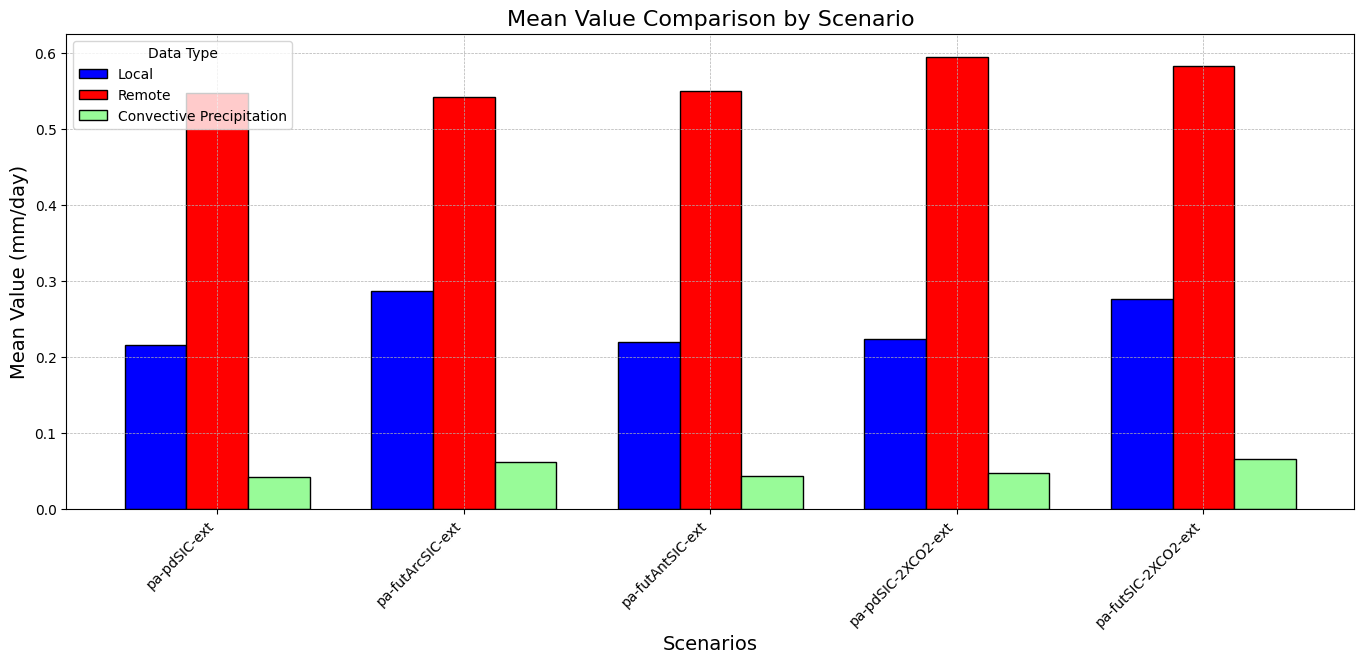

In [78]:
import iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def calculate_mean(cube):
    """
    Calculate the overall mean of a data cube.
    
    Parameters:
    cube (iris.cube.Cube): Input data cube.
    
    Returns:
    float: Mean value of the cube data.
    """
    return np.mean(cube.data)

# Calculate overall means for each dataset
mean_qflx = {key: calculate_mean(cube) for key, cube in arctic_qflx_datasets.items()}
mean_transport = {key: calculate_mean(cube) for key, cube in arctic_transport_datasets.items()}
mean_prc = {key: calculate_mean(cube) for key, cube in arctic_prc_datasets.items()}

# Prepare data for plotting
data = {
    'Experiment': [],
    'Type': [],
    'Mean Value': []
}

for key in scenarios.keys():
    data['Experiment'].append(key)
    data['Type'].append('QFLX')
    data['Mean Value'].append(mean_qflx[key])
    
    data['Experiment'].append(key)
    data['Type'].append('Transport')
    data['Mean Value'].append(mean_transport[key])
    
    data['Experiment'].append(key)
    data['Type'].append('PRC')
    data['Mean Value'].append(mean_prc[key])

df = pd.DataFrame(data)

# Pivot table for side-by-side bar plot
pivot_df = df.pivot(index='Experiment', columns='Type', values='Mean Value').fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))  # Increase figure size

# Define bar width and positions
bar_width = 0.25
bar_positions = np.arange(len(scenarios))

# Plot bars for QFLX and Transport side by side
ax.bar(bar_positions - bar_width, pivot_df['QFLX'], width=bar_width, color='#0000FF', edgecolor='black', label='Local')
ax.bar(bar_positions, pivot_df['Transport'], width=bar_width, color='#FF0000', edgecolor='black', label='Remote')

# Plot separate bars for PRC
ax.bar(bar_positions + bar_width, pivot_df['PRC'], width=bar_width, color='#98FB98', edgecolor='black', label='Convective Precipitation')

# Adding labels and title
plt.title('Mean Value Comparison by Scenario', fontsize=16)
plt.xlabel('Scenarios', fontsize=14)
plt.ylabel('Mean Value (mm/day)', fontsize=14)
plt.xticks(ticks=bar_positions, labels=scenarios.values(), rotation=45, ha='right')
plt.legend(title='Data Type', loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout to prevent clipping
plt.tight_layout(pad=2.0)  # Increase padding around the plot
plt.show()


In [79]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert to DataFrame for easier plotting
def to_dataframe(weighted_qflx, weighted_transport):
    """
    Converts the dictionaries of weighted data into DataFrames.
    
    Parameters:
    weighted_qflx (dict): Dictionary with scenario names as keys and Iris cubes as values.
    weighted_transport (dict): Dictionary with scenario names as keys and Iris cubes as values.

    Returns:
    tuple: DataFrames for QFLX and Transport.
    """
    # Extract monthly means
    months = np.arange(1, 13)  # Assuming data is for 12 months
    df_qflx = pd.DataFrame({key: cube.data.flatten() for key, cube in weighted_qflx.items()}, index=months)
    df_transport = pd.DataFrame({key: cube.data.flatten() for key, cube in weighted_transport.items()}, index=months)
    
    return df_qflx, df_transport

# Prepare data
df_qflx, df_transport = to_dataframe(arctic_qflx_datasets_weighted, arctic_transport_datasets_weighted)

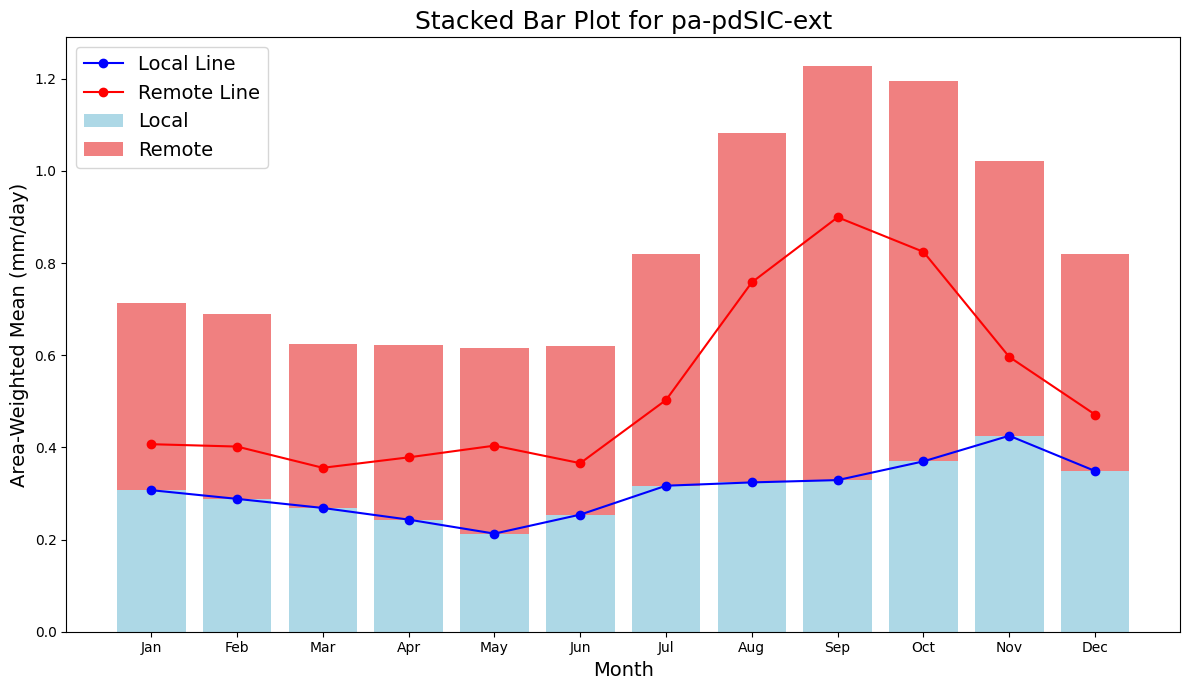

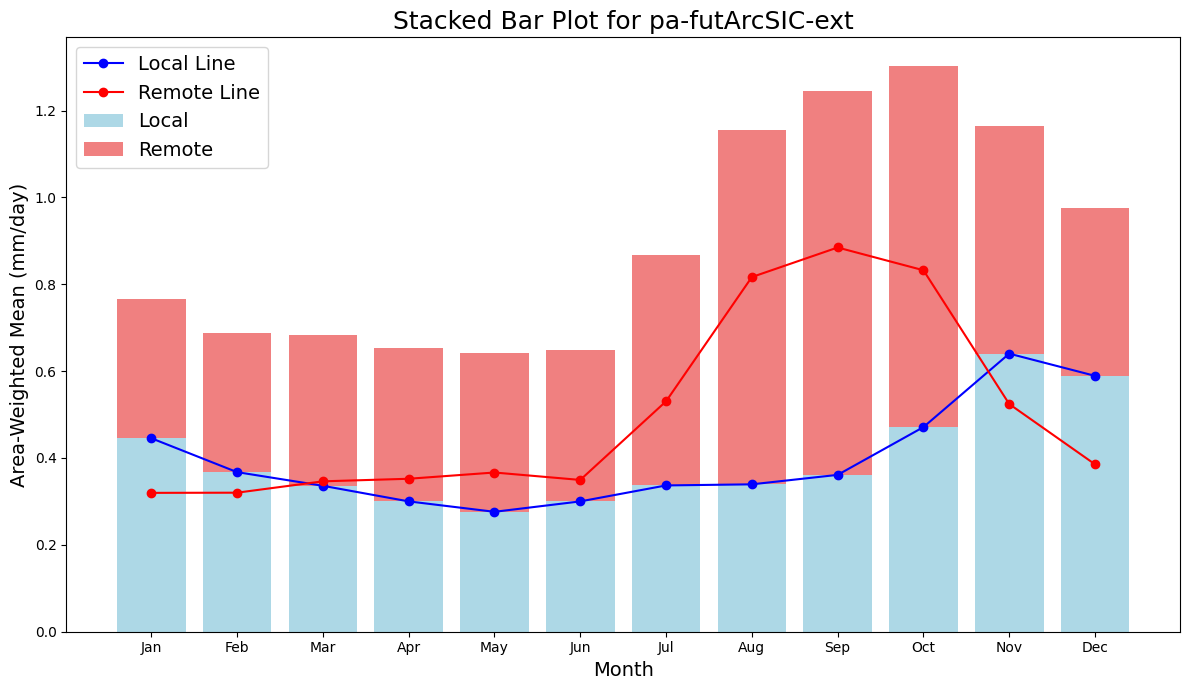

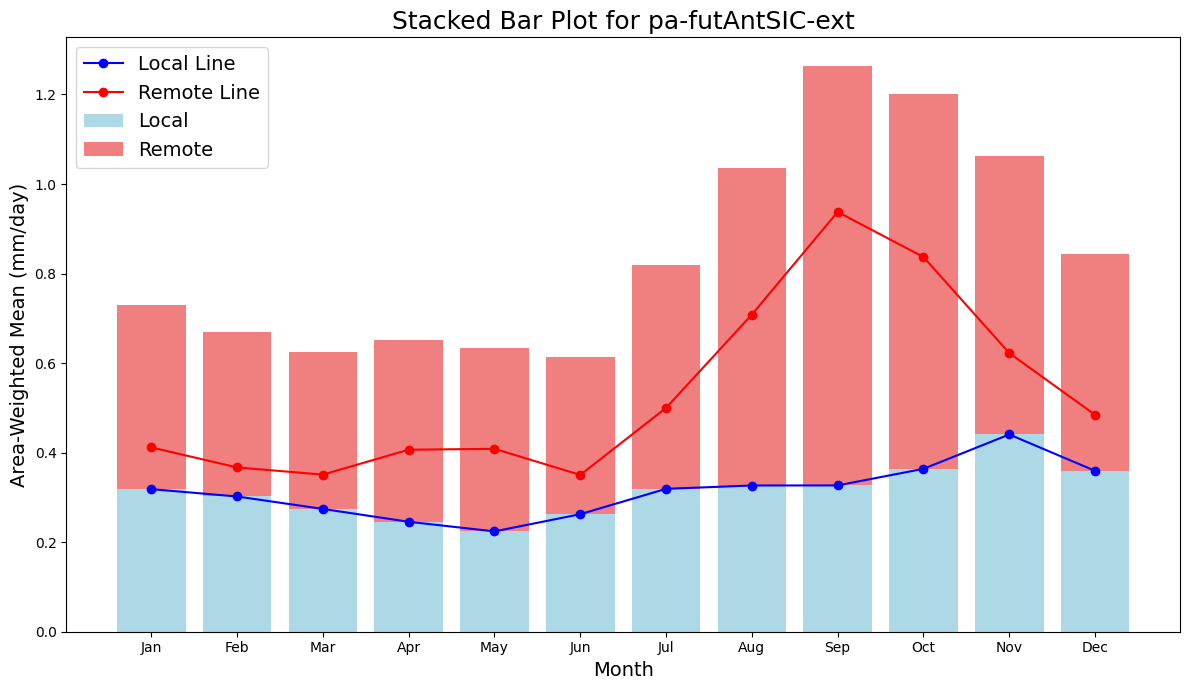

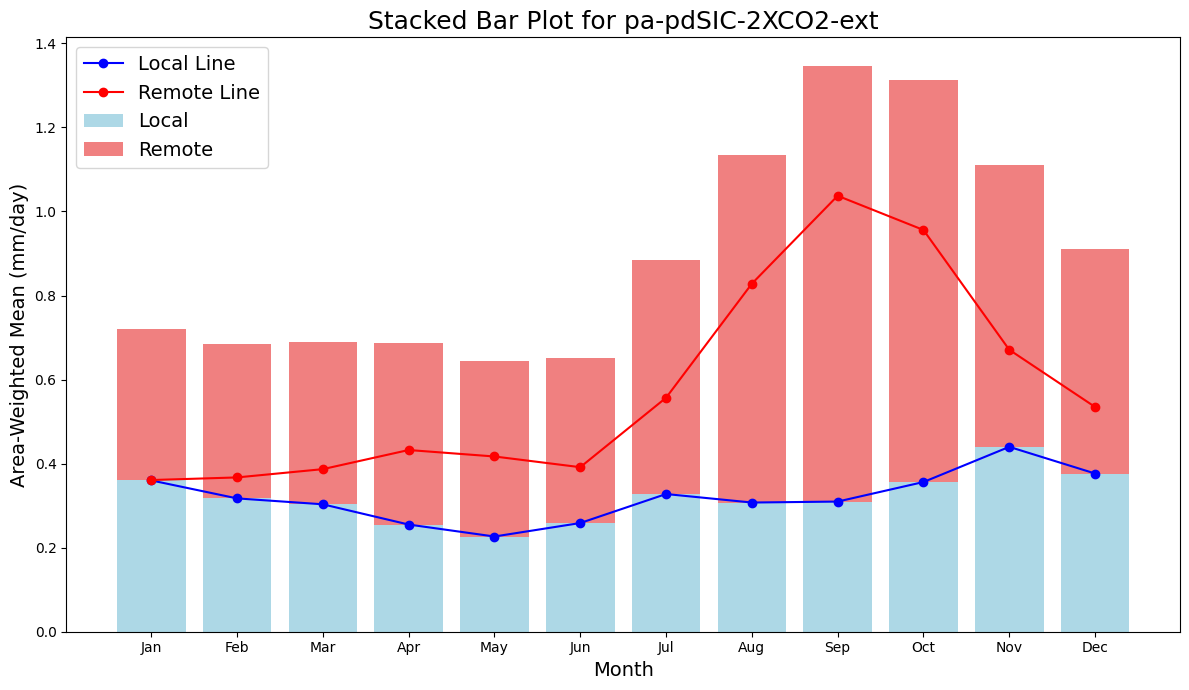

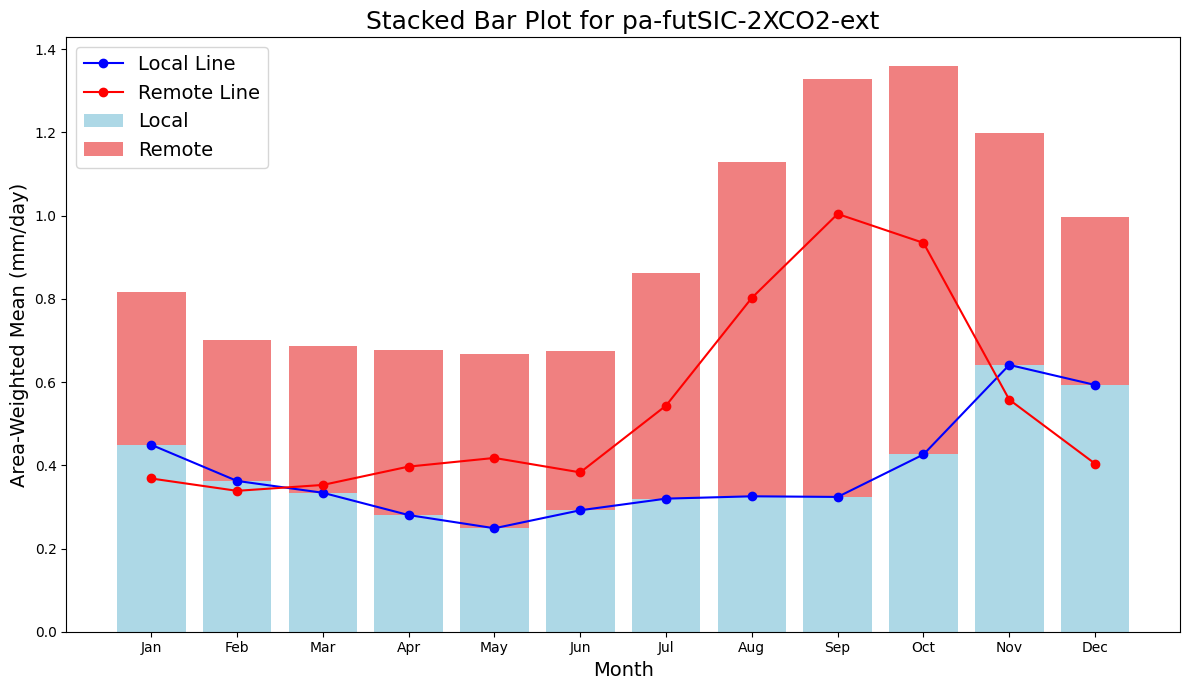

In [88]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_stacked_bar_for_experiments(df_qflx, df_transport, scenarios):
    """
    Plots stacked bar plots for each experiment scenario with two lines connecting the tops of the bars.

    Parameters:
    df_qflx (pd.DataFrame): DataFrame with QFLX data.
    df_transport (pd.DataFrame): DataFrame with Transport data.
    scenarios (dict): Dictionary mapping experiment keys to their names.
    """
    months = df_qflx.index

    for scenario_key in df_qflx.columns:
        qflx_data = df_qflx[scenario_key].values
        transport_data = df_transport[scenario_key].values
        
        # Get the scenario name from the dictionary
        scenario_name = scenarios.get(scenario_key, 'Unknown Scenario')
        
        fig, ax = plt.subplots(figsize=(12, 7))
        
        # Create stacked bar plot with pastel colors
        bars_qflx = ax.bar(months, qflx_data, color='lightblue', label='Local')
        bars_transport = ax.bar(months, transport_data, color='lightcoral', bottom=qflx_data, label='Remote')

        # Add lines connecting the tops of the bars
        tops_qflx = qflx_data
        tops_transport = qflx_data + transport_data

        ax.plot(months, tops_qflx, color='blue', linestyle='-', marker='o', label='Local Line')
        ax.plot(months, transport_data, color='red', linestyle='-', marker='o', label='Remote Line')

        ax.set_xlabel('Month', fontsize = 14)
        ax.set_ylabel('Area-Weighted Mean (mm/day)', fontsize = 14)
        ax.set_title(f'Stacked Bar Plot for {scenario_name}', fontsize = 18)
        ax.set_xticks(months)
        ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        ax.legend(loc='upper left', fontsize = 14)

        plt.tight_layout()
        plt.show()

# Convert to DataFrame for plotting
df_qflx, df_transport = to_dataframe(arctic_qflx_datasets_weighted, arctic_transport_datasets_weighted)

# Plot stacked bar plots for each experiment with names
plot_stacked_bar_for_experiments(df_qflx, df_transport, scenarios)

In [ ]:
scenario_key1 = 'expt1'
scenario_key2 = 'expt2'

months = df_qflx.index

qflx_data = df_qflx[scenario_key2].values - df_qflx[scenario_key1].values
transport_data = df_transport[scenario_key2].values - df_transport[scenario_key1].values
        
# Get the scenario name from the dictionary
scenario_name = scenarios.get(scenario_key1, 'Unknown Scenario')
        
fig, ax = plt.subplots(figsize=(12, 7))
        
        # Create stacked bar plot with pastel colors
#bars_qflx = ax.bar(months, qflx_data, color='lightblue', label='Local')
#bars_transport = ax.bar(months, transport_data, color='lightcoral', bottom=qflx_data, label='Remote')

# Add lines connecting the tops of the bars
tops_qflx = qflx_data 
tops_transport = qflx_data + transport_data
zero_line = np.zeros_like(months)

ax.plot(months, qflx_data, color='blue', linestyle='-', marker='o', label='Local')
ax.plot(months, transport_data, color='red', linestyle='-', marker='o', label='Remote')
ax.plot(months,zero_line, color='black', linestyle='--')


ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Area-Weighted Mean (mm/day)', fontsize=16)
ax.set_title(f'Sea ice loss effect', fontsize=20)
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(loc='upper left',  fontsize=16)

plt.tight_layout()
plt.show()

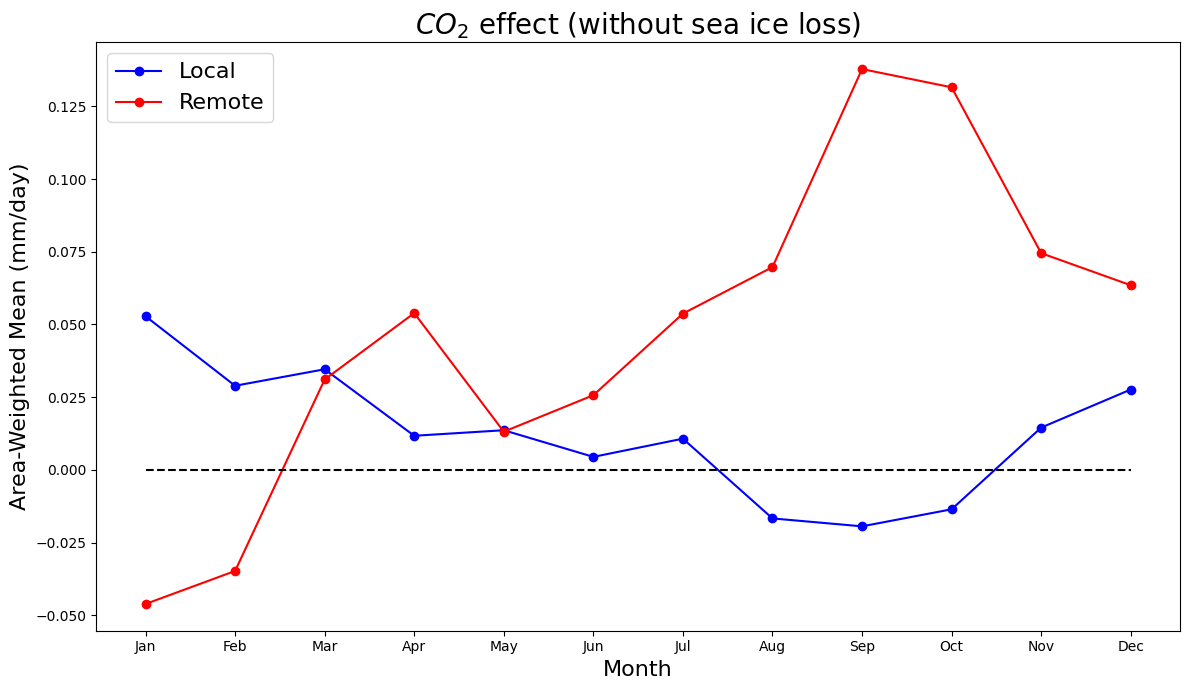

In [76]:
scenario_key1 = 'expt1'
scenario_key2 = 'expt4'

months = df_qflx.index

qflx_data = df_qflx[scenario_key2].values - df_qflx[scenario_key1].values
transport_data = df_transport[scenario_key2].values - df_transport[scenario_key1].values
        
# Get the scenario name from the dictionary
scenario_name = scenarios.get(scenario_key1, 'Unknown Scenario')
        
fig, ax = plt.subplots(figsize=(12, 7))
        
        # Create stacked bar plot with pastel colors
#bars_qflx = ax.bar(months, qflx_data, color='lightblue', label='Local')
#bars_transport = ax.bar(months, transport_data, color='lightcoral', bottom=qflx_data, label='Remote')

# Add lines connecting the tops of the bars
tops_qflx = qflx_data 
tops_transport = qflx_data + transport_data
zero_line = np.zeros_like(months)


ax.plot(months, qflx_data, color='blue', linestyle='-', marker='o', label='Local')
ax.plot(months, transport_data, color='red', linestyle='-', marker='o', label='Remote')
ax.plot(months, zero_line, color='black', linestyle='--')


ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Area-Weighted Mean (mm/day)', fontsize=16)
ax.set_title(r'$CO_{2}$ effect (without sea ice loss)', fontsize=20)
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(loc='upper left',  fontsize=16)

plt.tight_layout()
plt.show()

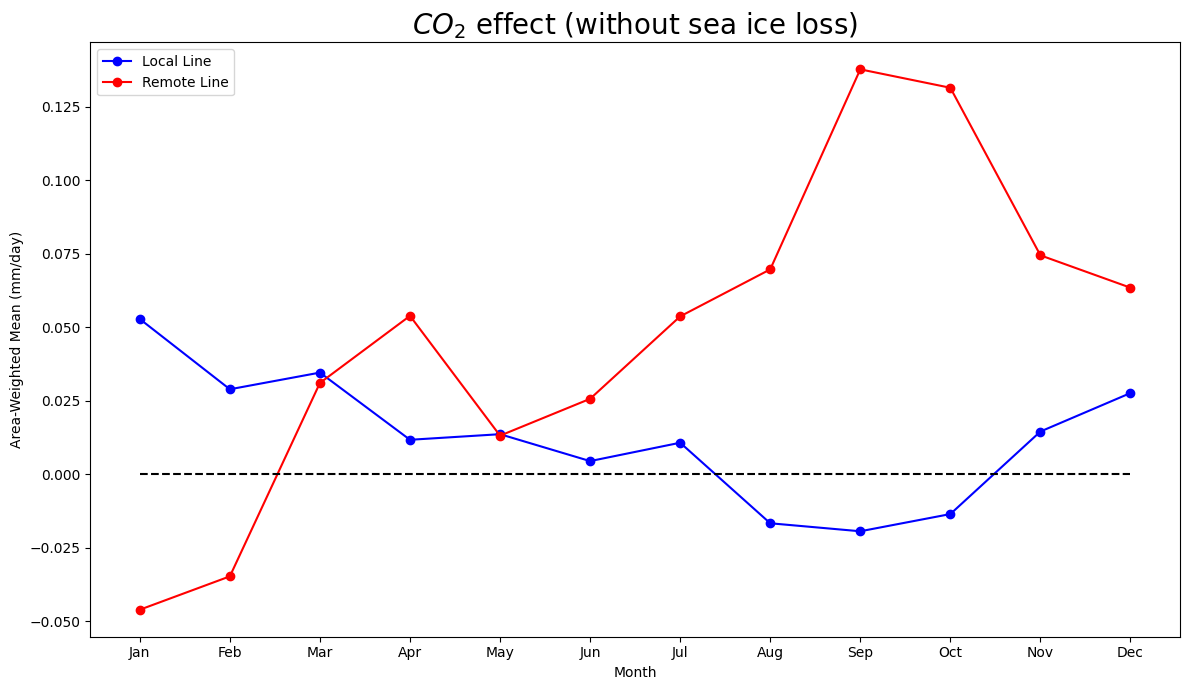

In [96]:
scenario_key1 = 'expt1'
scenario_key2 = 'expt4'

months = df_qflx.index

qflx_data = df_qflx[scenario_key2].values - df_qflx[scenario_key1].values
transport_data = df_transport[scenario_key2].values - df_transport[scenario_key1].values
        
# Get the scenario name from the dictionary
scenario_name = scenarios.get(scenario_key1, 'Unknown Scenario')
        
fig, ax = plt.subplots(figsize=(12, 7))
        
        # Create stacked bar plot with pastel colors
#bars_qflx = ax.bar(months, qflx_data, color='lightblue', label='Local')
#bars_transport = ax.bar(months, transport_data, color='lightcoral', bottom=qflx_data, label='Remote')

# Add lines connecting the tops of the bars
tops_qflx = qflx_data 
tops_transport = qflx_data + transport_data
zero_line = np.zeros_like(months)


ax.plot(months, qflx_data, color='blue', linestyle='-', marker='o', label='Local Line')
ax.plot(months, transport_data, color='red', linestyle='-', marker='o', label='Remote Line')
ax.plot(months, zero_line, color='black', linestyle='--')


ax.set_xlabel('Month')
ax.set_ylabel('Area-Weighted Mean (mm/day)')
ax.set_title(r'$CO_{2}$ effect (without sea ice loss)', fontsize=20)
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

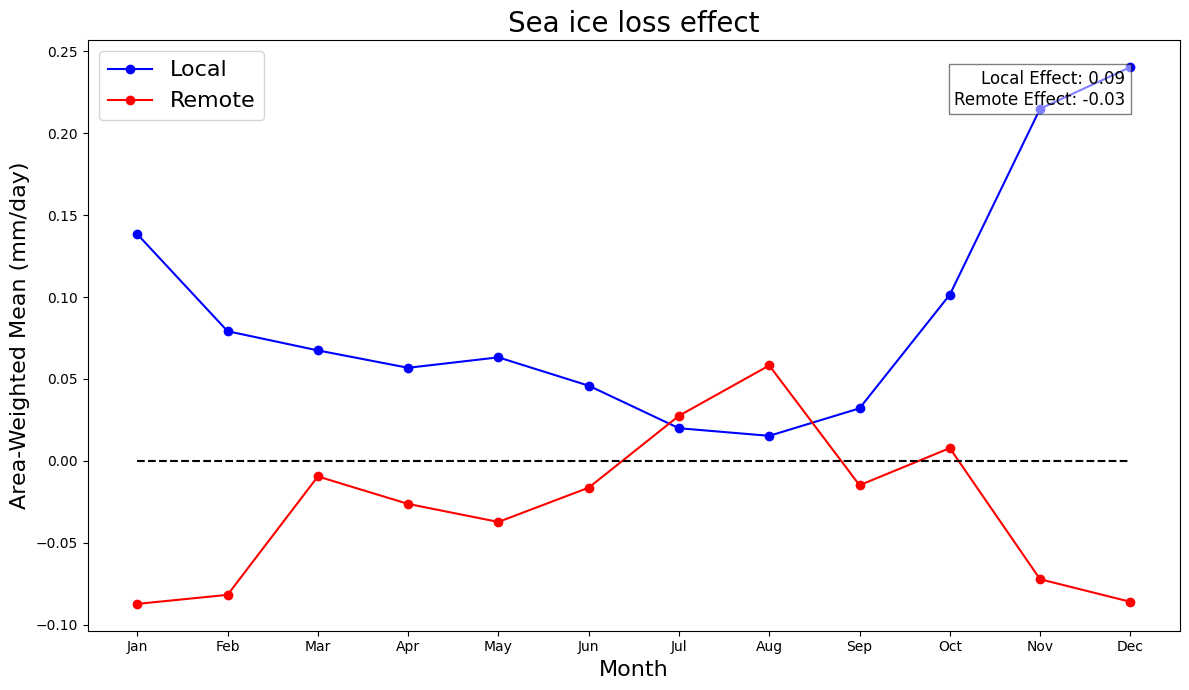

In [100]:
# Given scenario keys
scenario_key1 = 'expt1'
scenario_key2 = 'expt2'

months = df_qflx.index

qflx_data = df_qflx[scenario_key2].values - df_qflx[scenario_key1].values
transport_data = df_transport[scenario_key2].values - df_transport[scenario_key1].values

# Calculate total values
total_qflx = np.sum(qflx_data)/12
total_transport = np.sum(transport_data)/12

# Get the scenario name from the dictionary
scenario_name = scenarios.get(scenario_key1, 'Unknown Scenario')

fig, ax = plt.subplots(figsize=(12, 7))

# Add lines connecting the tops of the bars
tops_qflx = qflx_data 
tops_transport = qflx_data + transport_data
zero_line = np.zeros_like(months)

ax.plot(months, qflx_data, color='blue', linestyle='-', marker='o', label='Local')
ax.plot(months, transport_data, color='red', linestyle='-', marker='o', label='Remote')
ax.plot(months, zero_line, color='black', linestyle='--')

# Annotate the total values at the top right
textstr = f'Local Effect: {total_qflx:.2f}\nRemote Effect: {total_transport:.2f}'
ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right', 
        bbox=dict(facecolor='white', alpha=0.5))

ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Area-Weighted Mean (mm/day)', fontsize=16)
ax.set_title(f'Sea ice loss effect', fontsize=20)
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(loc='upper left', fontsize=16)
plt.tight_layout()
plt.show()

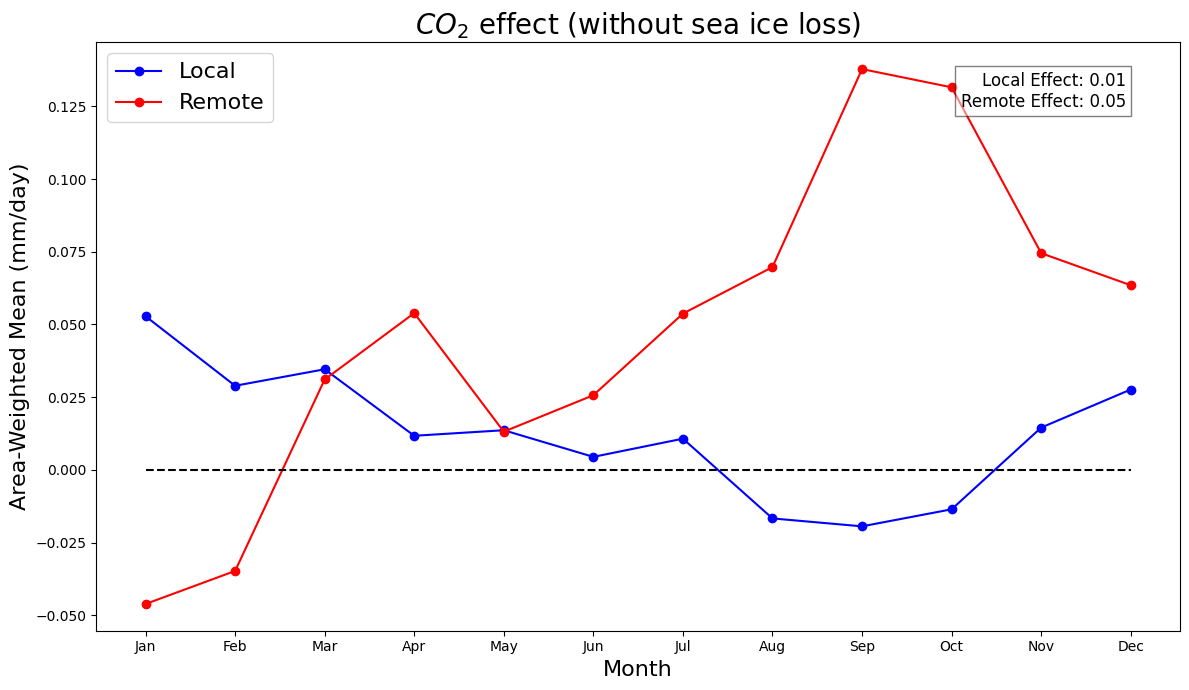

In [101]:
# Given scenario keys
scenario_key1 = 'expt1'
scenario_key2 = 'expt4'

months = df_qflx.index

qflx_data = df_qflx[scenario_key2].values - df_qflx[scenario_key1].values
transport_data = df_transport[scenario_key2].values - df_transport[scenario_key1].values

# Calculate total values
total_qflx = np.sum(qflx_data)/12
total_transport = np.sum(transport_data)/12

# Get the scenario name from the dictionary
scenario_name = scenarios.get(scenario_key1, 'Unknown Scenario')

fig, ax = plt.subplots(figsize=(12, 7))

# Add lines connecting the tops of the bars
tops_qflx = qflx_data 
tops_transport = qflx_data + transport_data
zero_line = np.zeros_like(months)

ax.plot(months, qflx_data, color='blue', linestyle='-', marker='o', label='Local')
ax.plot(months, transport_data, color='red', linestyle='-', marker='o', label='Remote')
ax.plot(months, zero_line, color='black', linestyle='--')

# Annotate the total values at the top right
textstr = f'Local Effect: {total_qflx:.2f}\nRemote Effect: {total_transport:.2f}'
ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right', 
        bbox=dict(facecolor='white', alpha=0.5))

ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Area-Weighted Mean (mm/day)', fontsize=16)
ax.set_title(r'$CO_{2}$ effect (without sea ice loss)', fontsize=20)
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(loc='upper left', fontsize=16)
plt.tight_layout()
plt.show()

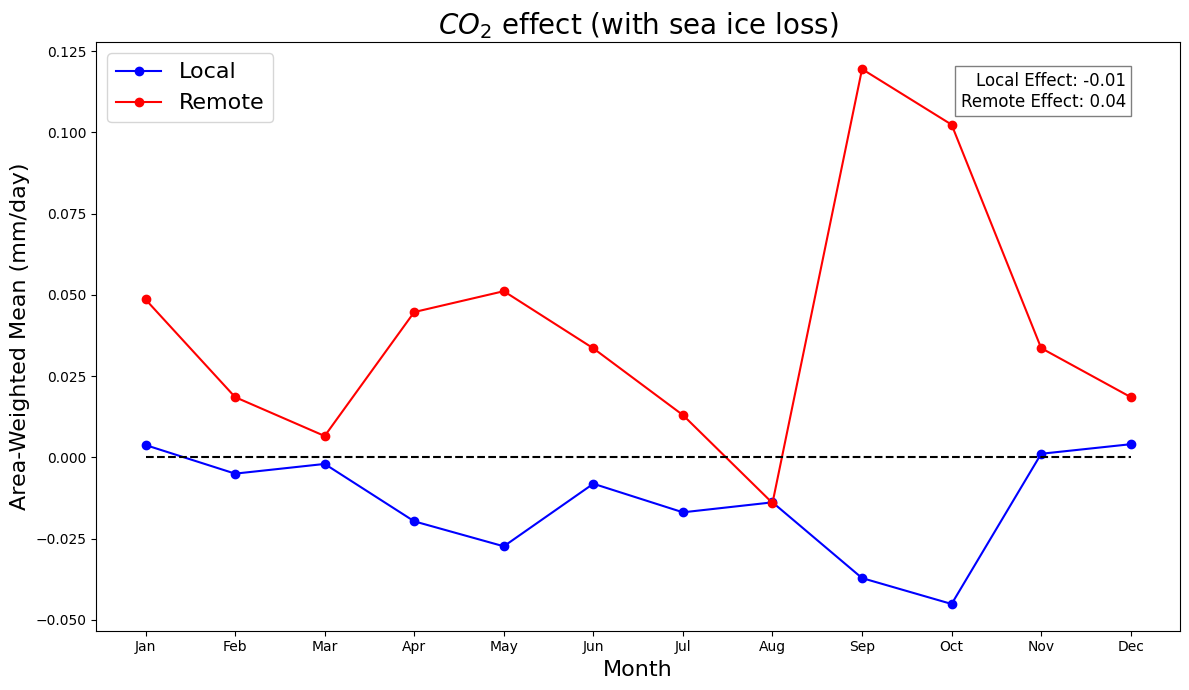

In [102]:
# Given scenario keys
scenario_key1 = 'expt2'
scenario_key2 = 'expt5'

months = df_qflx.index

qflx_data = df_qflx[scenario_key2].values - df_qflx[scenario_key1].values
transport_data = df_transport[scenario_key2].values - df_transport[scenario_key1].values

# Calculate total values
total_qflx = np.sum(qflx_data)/12
total_transport = np.sum(transport_data)/12

# Get the scenario name from the dictionary
scenario_name = scenarios.get(scenario_key1, 'Unknown Scenario')

fig, ax = plt.subplots(figsize=(12, 7))

# Add lines connecting the tops of the bars
tops_qflx = qflx_data 
tops_transport = qflx_data + transport_data
zero_line = np.zeros_like(months)

ax.plot(months, qflx_data, color='blue', linestyle='-', marker='o', label='Local')
ax.plot(months, transport_data, color='red', linestyle='-', marker='o', label='Remote')
ax.plot(months, zero_line, color='black', linestyle='--')

# Annotate the total values at the top right
textstr = f'Local Effect: {total_qflx:.2f}\nRemote Effect: {total_transport:.2f}'
ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right', 
        bbox=dict(facecolor='white', alpha=0.5))

ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Area-Weighted Mean (mm/day)', fontsize=16)
ax.set_title(r'$CO_{2}$ effect (with sea ice loss)', fontsize=20)
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(loc='upper left', fontsize=16)
plt.tight_layout()
plt.show()